In [1]:
# Import modules
import pandas as pd
import numpy as np
import spiceypy

# Import the SPICE meta kernel file
spiceypy.furnsh('kernel_meta.txt')

# Get the G*M value of the Sun
_, GM_SUN_PRE = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN_PRE[0]

In [2]:
# Get the orbital elements (mean values) of the asteroid 2020 JX1 from:
# https://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2020%20JX1
# ;old=0;orb=0;cov=1;log=0;cad=0#elem

# This time, we simply set constants. The later re-sampled values are stored
# in a pandas dataframe
AST_2020JX1_Q_AU = 1.006032017749843 # AU
AST_2020JX1_E = 0.2934873932898034
AST_2020JX1_I_DEG = 3.54821709679635 # degrees
AST_2020JX1_LNODE_DEG = 274.5788314475524 # degrees
AST_2020JX1_ARGP_DEG = 12.81238701655224 # degrees
AST_2020JX1_M0_DEG = 0.0 # degrees (and also radians, since its 0 ...)

# Orbital elements corresponding Epoch given in Julian Date (JD)
AST_2020JX1_EPOCH_JD = 2459038.680298393594

In [3]:
# The covariance matrix on the JPL site assumes the same dimensions as the mean
# values (AU, degrees, etc.)
# Further, the order is (column: left to right, rows: top to bottom)
#     eccentricity
#     perihelion
#     epoch
#     longitude of ascending node
#     argument of periapsis
#     inclination
AST_2020JX1_COV_MAT = \
    np.array([[3.5E-9,  -1.1E-10, -8.8E-9, -5.6E-9,   8.8E-9,   3.3E-8], \
              [-1.1E-10, 3.7E-12,  2.8E-10, 1.8E-10, -2.8E-10, -1.0E-9], \
              [-8.8E-9,  2.8E-10,  2.5E-8,  1.5E-8,  -2.0E-8,  -8.1E-8], \
              [-5.6E-9,  1.8E-10,  1.5E-8,  1.0E-8,  -1.4E-8,  -5.2E-8], \
              [8.8E-9,  -2.8E-10, -2.0E-8, -1.4E-8,   2.3E-8,   8.1E-8], \
              [3.3E-8,  -1.0E-9,  -8.1E-8, -5.2E-8,   8.1E-8,   3.0E-7]])

In [4]:
# Now, we re-sample possible solutions, based on the mean values and the
# covariance matrix. Re-sample size: 1000
AST_2020_JX1_SAMPLE = \
    np.random.multivariate_normal(mean=[AST_2020JX1_E, \
                                        AST_2020JX1_Q_AU, \
                                        AST_2020JX1_EPOCH_JD, \
                                        AST_2020JX1_LNODE_DEG, \
                                        AST_2020JX1_ARGP_DEG, \
                                        AST_2020JX1_I_DEG], \
                                  cov=AST_2020JX1_COV_MAT, size=1000)

In [5]:
# Store all re-samples now in a pandas dataframe. Consider the order of the
# orbital elements as defined by the covariance matrix
ast_2020_jx1_df = pd.DataFrame([])

# Eccentricity
ast_2020_jx1_df.loc[:, 'ECC'] = AST_2020_JX1_SAMPLE[:, 0]

# Perihelion (convert AU to km)
ast_2020_jx1_df.loc[:, 'PERIH_KM'] = \
    spiceypy.convrt(AST_2020_JX1_SAMPLE[:, 1], 'AU', 'km')

# Epoch in JD
ast_2020_jx1_df.loc[:, 'EPOCH_JD'] = AST_2020_JX1_SAMPLE[:, 2]

# Convert Epoch given in JD to Ephemeris Time
ast_2020_jx1_df.loc[:, 'EPOCH_ET'] = \
    ast_2020_jx1_df['EPOCH_JD'].apply(lambda x: \
                                      spiceypy.utc2et(str(x) + ' JD'))

# Longitude of ascending node, argument of periapsis and the inclination
# (in radians)
ast_2020_jx1_df.loc[:, 'LNODE_RAD'] = np.radians(AST_2020_JX1_SAMPLE[:, 3])
ast_2020_jx1_df.loc[:, 'ARGP_RAD'] = np.radians(AST_2020_JX1_SAMPLE[:, 4])
ast_2020_jx1_df.loc[:, 'I_RAD'] = np.radians(AST_2020_JX1_SAMPLE[:, 5])

# Finally, set the G*M value of the Sun
ast_2020_jx1_df.loc[:, 'GM_SUN'] = GM_SUN

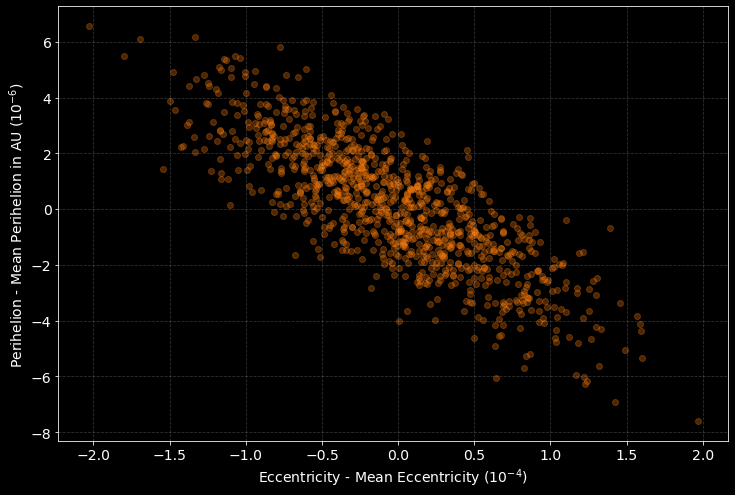

In [6]:
# Import matplotlib
from matplotlib import pyplot as plt

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the perihelion values vs. the eccentricity values in a scatter plot.
# Shift it by the mean values and finally scale it for nicer x and y ticks
ax.scatter((AST_2020_JX1_SAMPLE[:, 0] - AST_2020JX1_E) / (10.0**(-4)), \
           (AST_2020_JX1_SAMPLE[:, 1] - AST_2020JX1_Q_AU) / (10.0**(-6)), \
               color='tab:orange', alpha=0.3, marker='o')

# Add a grid for better readability
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set an x and y label
ax.set_xlabel('Eccentricity - Mean Eccentricity $(10^{-4})$')
ax.set_ylabel('Perihelion - Mean Perihelion in AU $(10^{-6})$')

# Save the figure
plt.savefig('asteroid_resample_e_q.png', dpi=300)

In [7]:
# Set the date-time of the Asteroid Day (yeah)
SAMPLE_ET = spiceypy.utc2et('2020-06-30T00:00:00')

# Set the Asteroid Day ET and mean anomaly (in radians)
ast_2020_jx1_df.loc[:, 'COMP_ET'] = SAMPLE_ET
ast_2020_jx1_df.loc[:, 'M0_RAD'] = np.radians(AST_2020JX1_M0_DEG)

# Compute the state vectors for all re-sampled orbital elements
ast_2020_jx1_df.loc[:, 'STATE_VEC'] = \
    ast_2020_jx1_df.apply(lambda x: \
                          spiceypy.conics(elts=x[['PERIH_KM', \
                                                  'ECC', \
                                                  'I_RAD', \
                                                  'LNODE_RAD', \
                                                  'ARGP_RAD', \
                                                  'M0_RAD', \
                                                  'EPOCH_ET', \
                                                  'GM_SUN']].values, \
                                          et=x['COMP_ET']), axis=1)

# And extract the positional information from the state vector
ast_2020_jx1_df.loc[:, 'POS_VEC_KM'] = \
    ast_2020_jx1_df['STATE_VEC'].apply(lambda x: x[:3])

In [8]:
# Let's compute the largest deviation / distance of the re-sampled position
# vector by using the scipy function cdist
from scipy.spatial.distance import cdist

DIST_MAT = cdist(np.array(list(ast_2020_jx1_df['POS_VEC_KM'].values)), \
                 np.array(list(ast_2020_jx1_df['POS_VEC_KM'].values)))

# Print the maximum distance of all position solution space / domain
print('Maximum distance of the predicted positions of 2020 JX1 in km: ' \
      f'{np.max(DIST_MAT)}')
print('\n')

Maximum distance of the predicted positions of 2020 JX1 in km: 1824.7702017441325




In [9]:
# We want to compute the ecliptic coordinates of the asteroid as seen from
# Earth ... or let's say: the solution space
# First, we need to compute the position vector of our home planet ...
EARTH_POSITION_KM, _ = spiceypy.spkgps(targ=399, et=SAMPLE_ET, \
                                       ref='ECLIPJ2000', obs=10)

In [10]:
# ... to determine the asteroid's position as seen from Earth
ast_2020_jx1_df.loc[:, 'POS_VEC_WRT_EARTH_KM'] = \
    ast_2020_jx1_df['POS_VEC_KM'].apply(lambda x: x - EARTH_POSITION_KM)

In [11]:
# Now let's compute the ecliptic longitude and latitude values
ast_2020_jx1_df.loc[:, 'ECLIP_LONG_DEG'] = \
    ast_2020_jx1_df['POS_VEC_WRT_EARTH_KM'] \
        .apply(lambda x: np.degrees(spiceypy.recrad(x)[1]))
ast_2020_jx1_df.loc[:, 'ECLIP_LAT_DEG'] = \
    ast_2020_jx1_df['POS_VEC_WRT_EARTH_KM'] \
        .apply(lambda x: np.degrees(spiceypy.recrad(x)[2]))

# Print the statistics of the results
print('Statistics for the Ecliptic Longitude: \n' \
      f'{ast_2020_jx1_df["ECLIP_LONG_DEG"].describe()}')
print('\n')
print('Statistics for the Ecliptic Latitude: \n' \
      f'{ast_2020_jx1_df["ECLIP_LAT_DEG"].describe()}')

Statistics for the Ecliptic Longitude: 
count    1000.000000
mean      109.446769
std         0.005369
min       109.431791
25%       109.443078
50%       109.446638
75%       109.450644
max       109.466238
Name: ECLIP_LONG_DEG, dtype: float64


Statistics for the Ecliptic Latitude: 
count    1000.000000
mean       26.973368
std         0.003825
min        26.962614
25%        26.970686
50%        26.973686
75%        26.975981
max        26.982502
Name: ECLIP_LAT_DEG, dtype: float64


In [12]:
# Assignment:
#   1. Visualise the long, lat coordinates in a sky map
#      (see: https://towardsdatascience.com/
#            space-science-with-python-space-maps-747c7d1eaf7f)
#   2. Compute the probability density function in spherical coordinates
#      (and plot it in the sky map. Hint: Use the Haversine metric!)